# Dynamic Analysis
In this notebook I plan to redo the whole path of experiments and create clean data that will be used as final results. Voltage on power source is set to 11.4V as that is the same as what batteries provide. Batbot weight 606.8g (5.95N) 686.6g with battery

In [1]:
import matplotlib.pyplot as plt
from utils import *
import numpy as np
import plotly.express as px
import pandas as pd
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [3]:
!python -m serial.tools.list_ports
daq_port = '/dev/ttyUSB0'
command_port = "/dev/ttyACM0"

/dev/ttyUSB0        
1 ports found


In [4]:
#measurements = read_measurements_df_6axis(port=daq_port, duration=5)
#measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/_.csv', index=False)

## Unit Correction
I will find the correct units of the measurements obtained and converted to N and N*m.

### Force
Added 399.8g (3.92N) on the structure and then removed it

<Axes: xlabel='Time'>

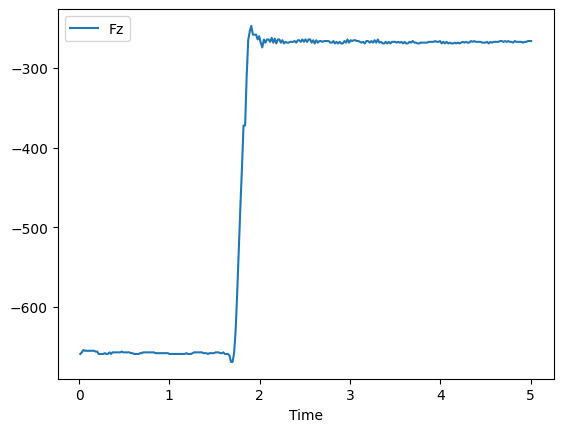

In [25]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/force_unit.csv')
measurements.plot(x='Time', y='Fz')

In [26]:
loaded = measurements[(measurements.Time<1)&(measurements.Time>0.5)].mean().Fz
unloaded = measurements[(measurements.Time<4.5)&(measurements.Time>4)].mean().Fz
measured_force = loaded - unloaded  #  measured for 399.8g
measured_force

-389.94636015325676

measured forces needs to be divided by 100 to obtain Newtons

### Torque
Added 399.8g (3.92N) at 13.5cm from x axis (0.5292Nm) then removed it.

<Axes: xlabel='Time'>

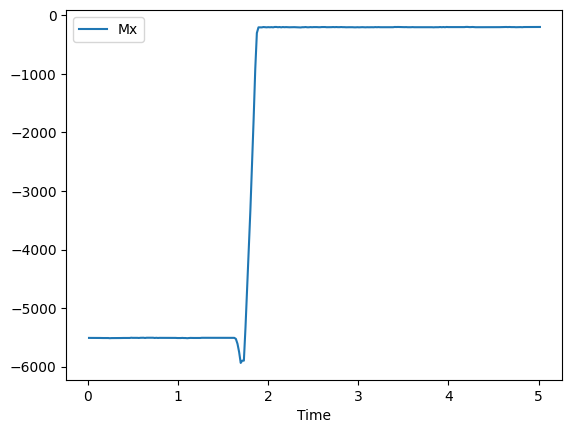

In [27]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/torque_unit.csv')
measurements.plot(x='Time', y='Mx')

In [28]:
loaded = measurements[(measurements.Time<1)&(measurements.Time>0.5)].mean().Mx
unloaded = measurements[(measurements.Time<4)&(measurements.Time>3.5)].mean().Mx
measured_torque = loaded - unloaded  #  measured for 399.8g
measured_torque

-5303.214285714286

measured torque most be divided by 10000 to get Nm

(Note: changes were then made in the function read_measurements_df_6axis())

## Hovering Angle and Batbot position for test
I aim to find the best position of the Batbot for the experiments, this means the one that has the highest average force upward and the least torque while static.

I will position the legs in their neutral state and keep them static and find the direction of the average force generated by the wings. The movements of the legs will later on be used to control the Batbot to the hovering position found. Thanks to experiments done before, I realized that the average force increases in the same direction with increasing flapping frequency, so I will use the average force direction as the new upward direction instead of only using the maximal force for that as done before.

### Calibration
First  I will calibrate the sensor putting the legs in neutral state and the wings folded, no flapping (convention from now on).

measurements = read_measurements_df_6axis(port=daq_port, duration=5)
measurements['Time'] = 0
calib = measurements.mean()
calib.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/calib_corrected.csv')


In [29]:
# Different calibrations done for the initial and corrected experiment.
calib = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/calib_corrected.csv', index_col=0).iloc[:,0]

In [30]:
calib

Time    0.000000
Fx      2.838694
Fy      2.363918
Fz     -8.870275
Mx     -0.689490
My      0.027889
Mz      0.099650
Name: 0, dtype: float64

### Initial Average Force
The values of the parameters are calculated based on the following configurations:

Desired:
leg_y = 90
leg_y_amplitude = 0
leg_x = 40  
leg_x_amplitude = 0
ellipse_angle = 1
motor = 270

Mapping when using command_batbot_V2():
motor = np.interp(motor, [0, 1], [260, 270])
leg_x = np.interp(leg_x, [0, 1], [40, 120])
leg_y = np.interp(leg_y, [0, 1], [30, 150])
leg_x_amplitude = np.interp(leg_x_amplitude, [0, 1], [0, 40])
leg_y_amplitude = np.interp(leg_y_amplitude, [0, 1], [0, 60])

motor = 1  # 270
leg_x = 0  # 40
leg_y = 0.5  # 90
leg_y_amplitude = 0  # 0
leg_x_amplitude = 0  # 0
ellipse_angle = 1  # Irrelevant
cmd = (motor, leg_x, leg_y, leg_x_amplitude, leg_y_amplitude, ellipse_angle)
command_batbot_V2(cmd, command_port)
time.sleep(1)  # To allow the Batbot to reach the attack angle and flapping speed
measurements = read_measurements_df_6axis(port=daq_port, duration=5) - calib
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/hovering_angle.csv', index=False)

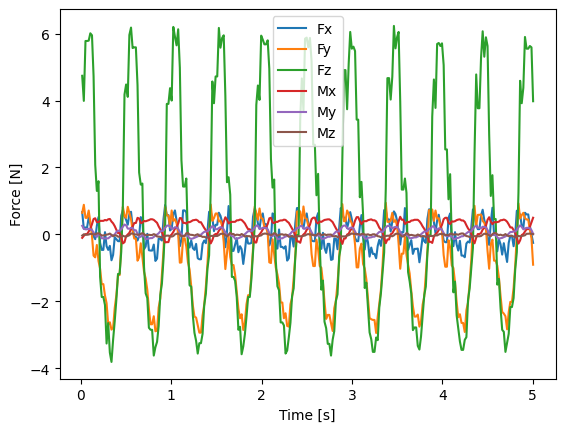

In [2]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/static_forces/231116/data/hovering_angle.csv')
ax = measurements.plot(x='Time')

# Adding a label to the y-axis
ax.set_ylabel('Force [N]')
ax.set_xlabel('Time [s]')

# Show the plot
plt.show()

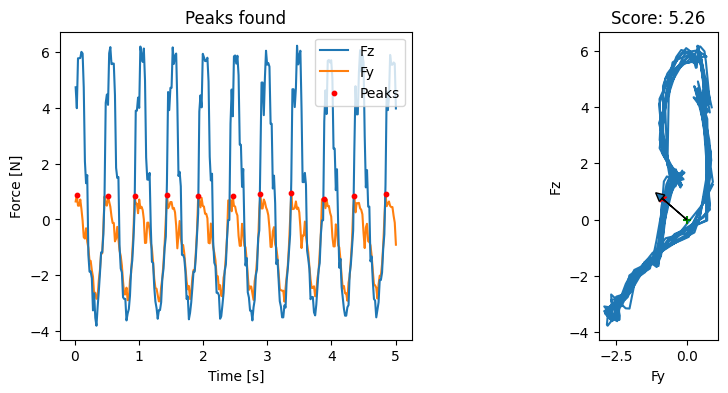

5.264054572673364

In [3]:
fitness_avg_force(measurements, plot=True, args={'peak_height':0, 'peak_distance':10})

Now we find the angle of the average force to rotate the Batbot in this new position

In [33]:
interpolated_df, _ = peak_slice_interpolate(measurements, args={'peak_height':0, 'peak_distance':10})

In [34]:
Fz, Fy = interpolated_df.mean()[['Fz', 'Fy']]

In [35]:
get_angle_degrees(Fy, Fz)-90

49.14272545505165

### Corrected Average Force
The Batbot will be rotated 50° and the experiment repeated.

motor = 1  # 270
leg_x = 0  # 40
leg_y = 0.5  # 90
leg_y_amplitude = 0  # 0
leg_x_amplitude = 0  # 0
ellipse_angle = 1  # Irrelevant
cmd = (motor, leg_x, leg_y, leg_x_amplitude, leg_y_amplitude, ellipse_angle)
command_batbot_V2(cmd, command_port)
time.sleep(1)  # To allow the Batbot to reach the attack angle and flapping speed
measurements = read_measurements_df_6axis(port=daq_port, duration=5) - calib
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/hovering_angle_corrected.csv', index=False)

<Axes: xlabel='Time'>

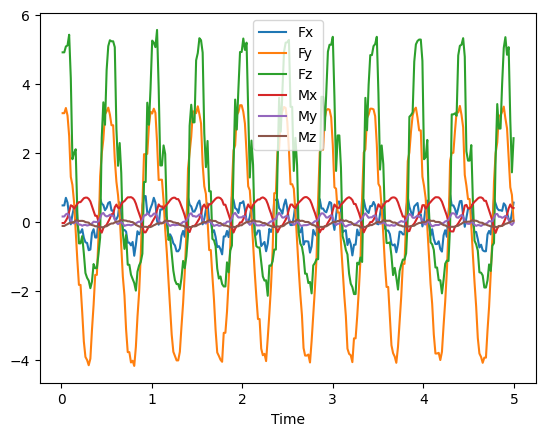

In [36]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/hovering_angle_corrected.csv')
measurements.plot(x='Time')

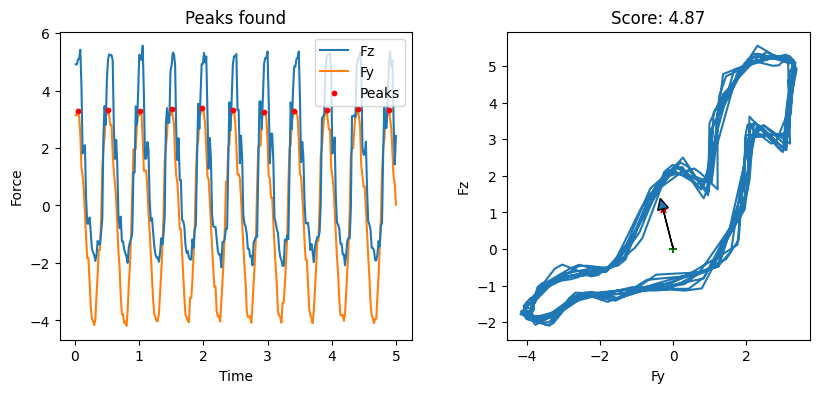

4.865373610509825

In [37]:
fitness_avg_force(measurements, plot=True, args={'peak_height':0, 'peak_distance':10})

In [38]:
interpolated_df, _ = peak_slice_interpolate(measurements, args={'peak_height':0, 'peak_distance':10})

In [39]:
Fz, Fy = interpolated_df.mean()[['Fz', 'Fy']]

In [40]:
get_angle_degrees(Fy, Fz)-90

14.319883084695249

The angle is the furthest that the testbench allows, nevertheless, it is still good enough.

## Folding against no Folding
The experiment will be repeated, disabling the folding capability to prove that folding provides a higher lift force. Besides the folding being disabled, the other parameters remain the same.

### No Folding

motor = 1 # 270 
leg_x = 0 # 40 
leg_y = 0.5 # 90 
leg_y_amplitude = 0 # 0 
leg_x_amplitude = 0 # 0 
ellipse_angle = 1 # Irrelevant 
cmd = (motor, leg_x, leg_y, leg_x_amplitude, leg_y_amplitude, ellipse_angle) 
command_batbot_V2(cmd, command_port) 
time.sleep(1) # To allow the Batbot to reach the attack angle and flapping speed
measurements = read_measurements_df_6axis(port=daq_port, duration=5) - calib 
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/no_folding.csv', index=False)

<Axes: xlabel='Time'>

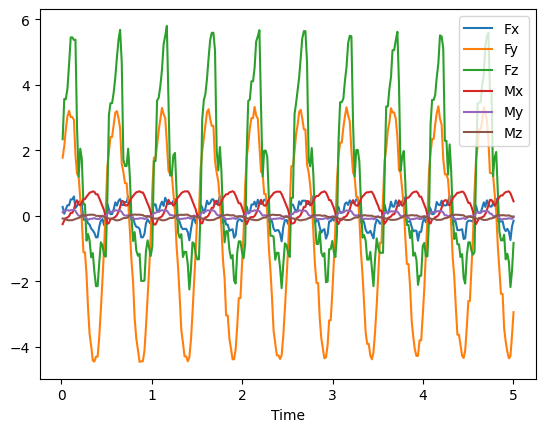

In [41]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/no_folding.csv')
measurements.plot(x='Time')

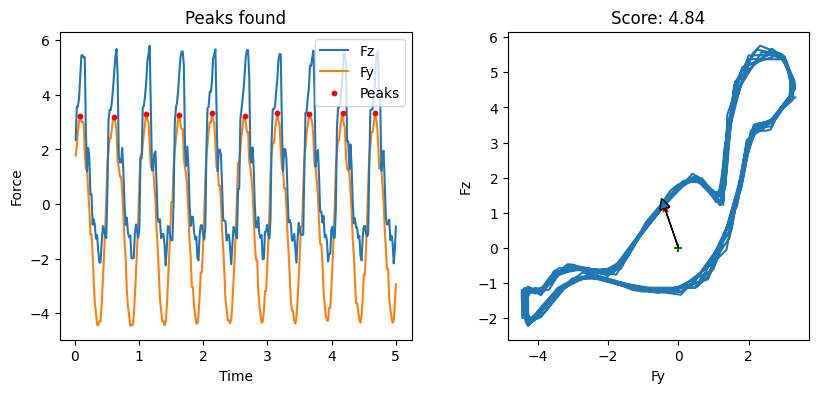

4.837910480429808

In [42]:
fitness_avg_force(measurements, plot=True, args={'peak_height':0, 'peak_distance':10})

### Leg movement
Out of curiosity I will also action the legs in the so far supposed to be the best parameters (keeping in mind that the logical step is to do an optimization phase first, but for curiosity 

In [43]:
motor = 1 # 270 
leg_x = 0 # 40 
leg_y = 0.5 # 90 
leg_y_amplitude = 0.5 # 30 
leg_x_amplitude = 1 # 40 
ellipse_angle = 1 # Irrelevant 
cmd = (motor, leg_x, leg_y, leg_x_amplitude, leg_y_amplitude, ellipse_angle) 
command_batbot_V2(cmd, command_port) 
time.sleep(1) # To allow the Batbot to reach the attack angle and flapping speed
measurements = read_measurements_df_6axis(port=daq_port, duration=5) - calib 
measurements.to_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/leg_movement.csv', index=False)

Sending command to batbot leg_x: 40.0
leg_y: 90.0
leg_x_amplitude: 40.0
leg_y_amplitude: 30.0
Ellipse: 1
Sent!


<Axes: xlabel='Time'>

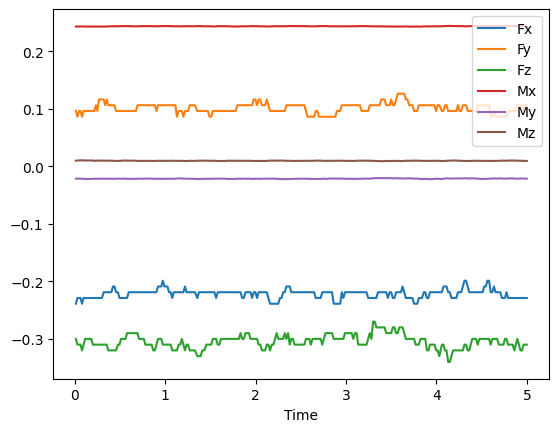

In [44]:
measurements = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/leg_movement.csv')
measurements.plot(x='Time')

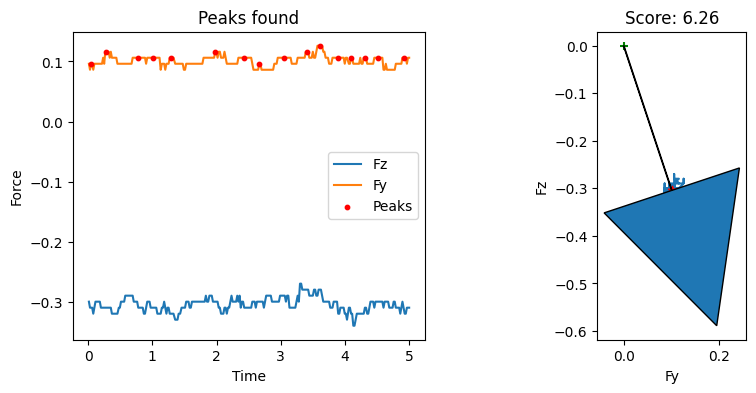

6.255120324847097

In [45]:
fitness_avg_force(measurements, plot=True, args={'peak_height':0, 'peak_distance':10})

### Comparison

In [50]:
folding = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/hovering_angle_corrected.csv')
no_folding = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/no_folding.csv')
leg_movement = pd.read_csv('/home/anuarsantoyo/PycharmProjects/Batbot/analysis/forces/231116/data/leg_movement.csv')

In [51]:
folding_score = fitness_avg_force(folding)
no_folding_score = fitness_avg_force(no_folding)
leg_movement_score = fitness_avg_force(leg_movement)

In [52]:
folding, _ = peak_slice_interpolate(folding)
no_folding, _ = peak_slice_interpolate(no_folding)
leg_movement, _ = peak_slice_interpolate(leg_movement)

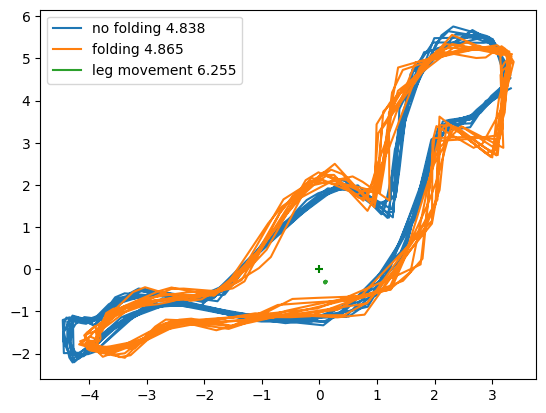

In [53]:
plt.scatter(0, 0, c='g', marker='+')

plt.plot(no_folding.Fy,no_folding.Fz, label=f'no folding {round(no_folding_score,3)}')
plt.plot(folding.Fy,folding.Fz, label=f'folding {round(folding_score,3)}')
plt.plot(leg_movement.Fy,leg_movement.Fz, label=f'leg movement {round(leg_movement_score,3)}')

#Fz, Fy = no_folding.mean()[['Fz', 'Fy']]
#plt.scatter(Fy, Fz, c='r', marker='*')
#plt.arrow(0, 0, Fy, Fz, head_width=0.3, head_length=0.3)
#Fz, Fy = folding.mean()[['Fz', 'Fy']]
#plt.scatter(Fy, Fz, c='r', marker='*')
#plt.arrow(0, 0, Fy, Fz, head_width=0.3, head_length=0.3)
#Fz, Fy = leg_movement.mean()[['Fz', 'Fy']]
#plt.scatter(Fy, Fz, c='r', marker='*')
#plt.arrow(0, 0, Fy, Fz, head_width=0.3, head_length=0.3)
plt.legend()
plt.show()

In [54]:
# Calculating the means

folding_mean = folding.mean()[['Fy', 'Fz']]
folding_mean['score'] = folding_score

no_folding_mean = no_folding.mean()[['Fy', 'Fz']]
no_folding_mean['score'] = no_folding_score

leg_movement_mean = leg_movement.mean()[['Fy', 'Fz']]
leg_movement_mean['score'] = leg_movement_score
# Combining the means into a single dataframe

df_means = pd.DataFrame({
    'no_folding': no_folding_mean,
    'folding': folding_mean,
    'leg_movement': leg_movement_mean
})

In [55]:
df_means

,no_folding,folding,leg_movement
Fy,-0.386323,-0.278911,0.101078
Fz,1.127539,1.092627,-0.304304
score,4.837910,4.865374,6.255120
